# PRISMA matched-filter diagnostics and uncertainty propagation

This notebook documents how the PRISMA pipeline builds the background statistics, target spectra, and $\sigma_{RMN}$ noise term that later feeds the plume-level uncertainty analysis.


## 1. Configure scene assets and load radiances
Import the repository modules, declare the PRISMA L1/L2C/DEM/LUT/SNR files, and ensure the notebook can locate `scripts/`. Reading the radiance cube with `prisma_utils.prisma_read` also returns centre wavelengths (`cw_array`) and FWHM per band; basic min/max stats validate the inputs.


In [1]:
import os
import sys
from pathlib import Path
import zipfile
import tempfile
import contextlib

import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
os.environ.setdefault('PYTHONPATH', str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts.pipelines import prisma_pipeline
from scripts.core import noise, targets, lut, matched_filter
from scripts.satellites import prisma_utils

PRISMA_CONFIG = {
    'l1': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip'),
    'l2c': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/prisma/Northern_State_Sudan_20200401/20200401085313_20200401085318/PRS_L2C_STD_20200401085313_20200401085318_0001.zip'),
    'dem': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/DEM_1Km/srtm30plus_v11_land.nc'),
    'lut': Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/LUTs/CH4_lut.hdf5'),
    'snr_reference': REPO_ROOT / 'notebooks' / 'outputs' / 'prisma' / '20200401085313' / 'snr_reference_columnwise.npz',
    'output_dir': NOTEBOOK_ROOT / 'notebooks' / 'outputs' / 'pipeline_diagnostics',
    'min_wavelength': 2100.0,
    'max_wavelength': 2450.0,
    'k': 1,
}


CONFIG = PRISMA_CONFIG
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)
print('Configuration loaded.')

Configuration loaded.


## 2. Handle zipped inputs and inspect radiance statistics
`_prepare_prisma_path` extracts `.he5` files from the L1/L2C archives when necessary so downstream readers receive filesystem paths. After extraction, the notebook logs radiance shape and dynamic range for traceability.


In [2]:
# Prepare paths (extract from zip if necessary)
cleanup_stack = contextlib.ExitStack()
temp_dir = cleanup_stack.enter_context(tempfile.TemporaryDirectory())

def _prepare_prisma_path(path: str) -> str:
    if path.lower().endswith(".zip"):
        extracted = prisma_utils.extract_he5_from_zip(path, temp_dir)
        if not extracted:
            raise FileNotFoundError(f"No .he5 file found inside {path}")
        return extracted
    return path

L1_path = _prepare_prisma_path(str(CONFIG['l1']))
L2C_path = _prepare_prisma_path(str(CONFIG['l2c']))

# Load radiance data
rads_array, cw_array, fwhm_array, _, _, _, _, _, _, _ = prisma_utils.prisma_read(L1_path)

# Print shape and summary statistics
print(f'Rads array shape: {rads_array.shape}')
print(f'Rads array min: {np.nanmin(rads_array)}')
print(f'Rads array max: {np.nanmax(rads_array)}')
print(f'Rads array mean: {np.nanmean(rads_array)}')


Rads array shape: (1000, 1000, 230)
Rads array min: 0.0
Rads array max: 21.04199981689453
Rads array mean: 6.2146782875061035


## 3. Restrict to absorption bands
Compute the mean centre wavelength per band (`mean_cw`) and select indices within 2.1-2.45 um, producing matched radiance, wavelength, and FWHM subsets. This ensures the matched filter only sees the methane absorption window while keeping VNIR/SWIR overlap manageable.


In [3]:
# Subselect bands
mean_cw = np.mean(cw_array, axis=0)
band_indices = targets.select_band_indices(mean_cw, CONFIG['min_wavelength'], CONFIG['max_wavelength'])
rads_array_subselection = rads_array[:, :, band_indices]
cw_subselection = cw_array[:, band_indices]
fwhm_subselection = fwhm_array[:, band_indices]
mean_cw_subselection = mean_cw[band_indices]

print(f'Subselected rads array shape: {rads_array_subselection.shape}')

Subselected rads array shape: (1000, 1000, 47)


## 4. Background clustering and statistics
Run k-means (`k=1` in this example) on the restricted cube to derive the classification mask plus per-cluster mean radiance and covariance matrices. These statistics define $\mu$ and $\Sigma$ for the matched filter weights $w = \Sigma^{-1}(t-\mu)$.


In [4]:
# k-means classification
classified_image = matched_filter.k_means_hyperspectral(rads_array_subselection, CONFIG['k'])
mean_radiance, covariance_matrices = matched_filter.calculate_statistics(rads_array_subselection, classified_image, CONFIG['k'])

print(f'Mean radiance shape: {mean_radiance.shape}')
print(f'Covariance matrices shape: {covariance_matrices.shape}')


Mean radiance shape: (1, 47)
Covariance matrices shape: (1, 47, 47)


## 5. Generate LUT targets
Extract solar zenith angle, water vapour, and bounding box from the L1/L2C metadata, estimate the mean elevation over the footprint, and call `lut.generate_library` to simulate spectra for the requested concentration grid. `targets.generate_columnwise_targets` resamples the LUT outputs to the PRISMA bandpasses, delivering the `target_spectra` vector used in the matched filter.


In [5]:
# Generate target spectra
SZA = prisma_utils.prismaL1_SZA_read(L1_path)
meanWV, _, _, _ = prisma_utils.prismaL2C_WV_read(L2C_path)
bbox = prisma_utils.prismaL2C_bbox_read(L2C_path)
mean_elevation = lut.mean_elev_from_dem(str(CONFIG['dem']), bbox)

concentrations = [0.0, 1000, 2000, 4000, 8000, 16000, 32000, 64000]
ground_km = lut.normalize_ground_km(mean_elevation)
water_gcm2 = lut.normalize_wv_gcm2(meanWV)

simRads_array, simWave_array = lut.generate_library(
    concentrations, str(CONFIG['lut']), zenith=SZA, sensor=120, ground=ground_km, water=water_gcm2, order=1
)

target_spectra = targets.generate_columnwise_targets(
    cw_subselection,
    fwhm_subselection,
    simRads_array,
    simWave_array,
    concentrations,
)

print(f'Target spectra shape: {target_spectra.shape}')
print(f'Target spectra min: {np.nanmin(target_spectra)}')
print(f'Target spectra max: {np.nanmax(target_spectra)}')
print(f'Target spectra mean: {np.nanmean(target_spectra)}')


Sun Zenith Angle (degrees): 25.568771
Mean Water Vapor (g/cm^2): 1.4442798
Mean Elevation within Bounding Box in Km: 0.3316592102050781
Target spectra shape: (47, 1000)
Target spectra min: -1.1312736770421937e-05
Target spectra max: -1.7175467676270614e-09
Target spectra mean: -3.8569624444586355e-06


## 6. Map the SNR reference to the scene cube
Load the sensor-specific `ColumnwiseSNRReference`, subset it to the retained wavelengths, and call `noise.compute_sigma_map_from_reference` on the band-major cube. The resulting `sigma_cube` estimates column-wise detector noise under the assumption that the SNR reference matches the acquisition conditions.


In [6]:
# Load SNR reference and compute sigma_cube
reference = noise.ColumnwiseSNRReference.load(str(CONFIG['snr_reference']))
reference_subset = reference.subset_by_wavelengths(mean_cw_subselection).ensure_column_count(
    rads_array_subselection.shape[1]
)
rad_cube_brc = np.transpose(rads_array_subselection, (2, 0, 1))
sigma_cube = noise.compute_sigma_map_from_reference(reference_subset, rad_cube_brc)

print(f'Sigma cube shape: {sigma_cube.shape}')
print(f'Sigma cube min: {np.nanmin(sigma_cube)}')
print(f'Sigma cube max: {np.nanmax(sigma_cube)}')
print(f'Sigma cube mean: {np.nanmean(sigma_cube)}')


Sigma cube shape: (47, 1000, 1000)
Sigma cube min: 0.0010738118767934823
Sigma cube max: 0.020124821663153013
Sigma cube mean: 0.007414357170422006


## 7. Propagate RMN uncertainty and visualise
`noise.propagate_rmn_uncertainty` folds the noise cube, classification mask, mean radiance, and target vector into $\sigma_{RMN}$, i.e., the instrument-noise contribution to the matched-filter variance. Plotting the map reveals where detector noise dominates; these pixels later receive the clutter term $\sigma_{Surf}$ in the scene-level uncertainty notebook.


Sigma RMN shape: (1000, 1000)
Sigma RMN min: 80.72767639160156
Sigma RMN max: 348.7410888671875
Sigma RMN mean: 200.12159729003906


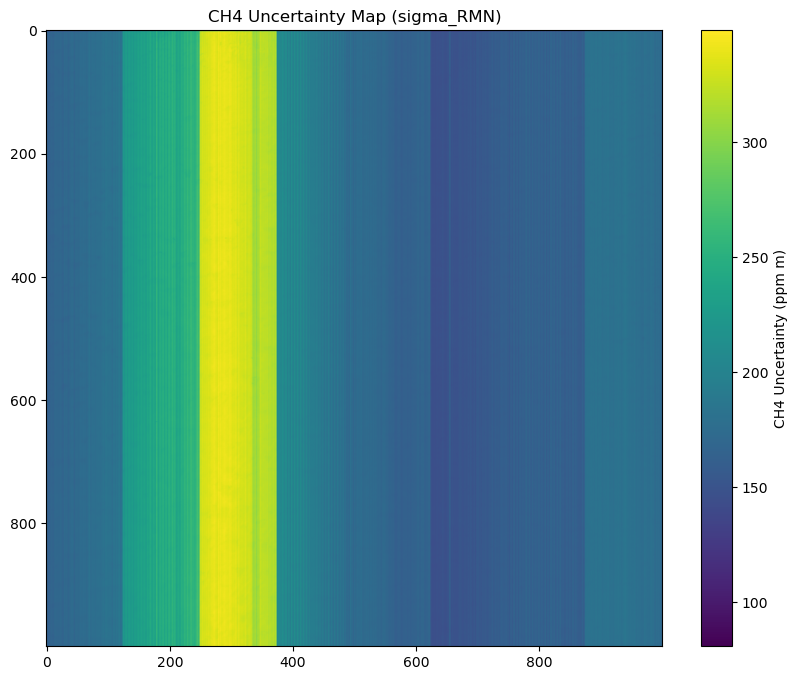

In [7]:
# Propagate uncertainty
sigma_rmn = noise.propagate_rmn_uncertainty(
    sigma_cube=sigma_cube,
    classified_image=classified_image,
    mean_radiance=mean_radiance,
    target_spectra=target_spectra,
).astype(np.float32)

print(f'Sigma RMN shape: {sigma_rmn.shape}')
print(f'Sigma RMN min: {np.nanmin(sigma_rmn)}')
print(f'Sigma RMN max: {np.nanmax(sigma_rmn)}')
print(f'Sigma RMN mean: {np.nanmean(sigma_rmn)}')

plt.figure(figsize=(10, 8))
plt.imshow(sigma_rmn, cmap='viridis')
plt.colorbar(label='CH4 Uncertainty (ppm m)')
plt.title('CH4 Uncertainty Map (sigma_RMN)')
plt.show()

cleanup_stack.close()